In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [6]:
try:
  raise ValueError # <<<< force install until pypi is updated
  #import pynumdiff
except:
  !pip install git+https://github.com/florisvb/PyNumDiff # <<<<<< use the latest version, not on pypi yet
  import pynumdiff

  Cloning https://github.com/florisvb/PyNumDiff to /tmp/pip-req-build-z79jdixg
  Running command git clone --filter=blob:none --quiet https://github.com/florisvb/PyNumDiff /tmp/pip-req-build-z79jdixg
  Resolved https://github.com/florisvb/PyNumDiff to commit 5d960720f6b5962ade857394dec7b4442e7954b2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pynumdiff: filename=pynumdiff-0.1.4.dev258+g5d960720f-py3-none-any.whl size=60235 sha256=102f6bee3ff558511f9c048c37f33dfb4e94f4b313c0fdd5dd5d1cfe9fa1f6c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9igd6so/wheels/d5/d2/d5/e088d09db33998cc8a03da8ed5da944b4512c71615c0dc9e72
Successfully built pynumdiff


In [3]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 4.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-1w9uw1in
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-1w9uw1in
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=1baad0ab9c0377aa8aa5fc33a3c79b9b81e21dae336d3c59fa265a86fbd00124
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9up4k99/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [7]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now we will not include k as a static state. Instead, we will be using SINDy to find all the parameter values, which includes k.

#### Given the planar drone dynamics

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[lightblue]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[lightblue]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[lightblue]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

#### Consider the following scenario

We have made measurements of $x$, and we want to know $\dot{x}$. Pretend we know nothing else.


# Dynamics and measurement functions

Here we will use versions of `f` and `h` that do not consider $k$ to be a state.

In [8]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

In [9]:
print(f(None, None, return_state_names=True))

['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']


In [10]:
print(h(None, None, return_measurement_names=True))

['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']


# Run MPC simulation

Let's use a more dynamic (``random``) trajectory now, and enforce smoother control inputs with a larger `rterm`.

In [11]:
dt = 0.1
tsim_length = 20
tsim = np.arange(0, tsim_length, step=dt)

In [12]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h=h, dt=dt, tsim_length=tsim_length,
                                                                    trajectory_shape='random',
                                                                    rterm=1e-1)

### Plot the x, z trajectory

Text(0, 0.5, 'z pos')

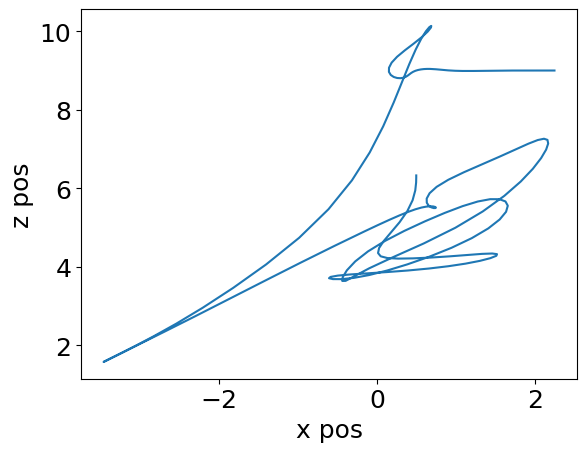

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

In [14]:
x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)

# Now add a little noise and pretend we have real data

In [15]:
noise_std = 0.3
state_x_noisy = x_sim_df['x'] + np.random.normal(0, noise_std, len(x_sim_df['x']))

<Axes: xlabel='Time', ylabel='x'>

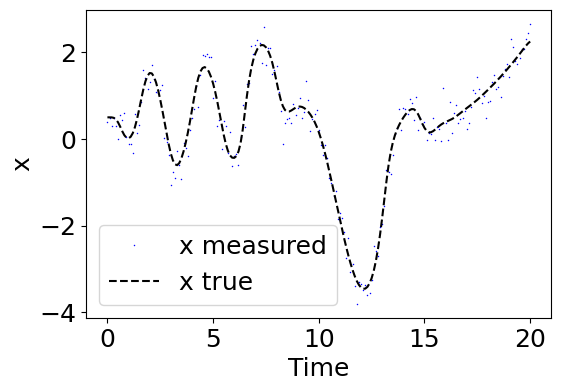

In [16]:
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, None, label_var='x')

# Compute naive numerical derivatives

There are many ways to do this. Here are few common methods -- when properly tuned, it does not matter which one you use.
  * First order finite difference: just calculate difference between neighboring points
  * Savitzky Golay filter: frequency domain sliding polynomial fit
  * Spectral derivative: take a derivative in the frequency domain
  * Total variation regularization: balance accuracy and variation

### First Order Finite Difference

Serves as motivation to use other methods.

Note: if you apply iterations, the results are actually quite good. Use second or fourth order to remove delay.

<Axes: xlabel='Time', ylabel='x_dot'>

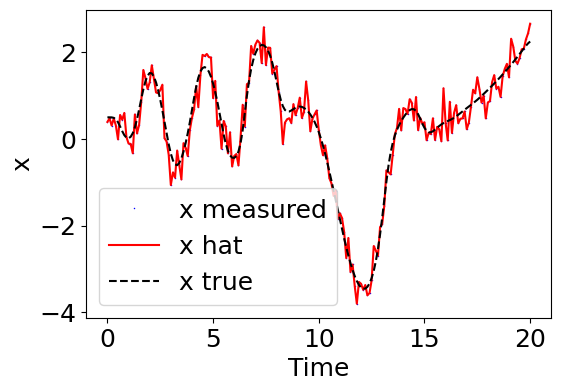

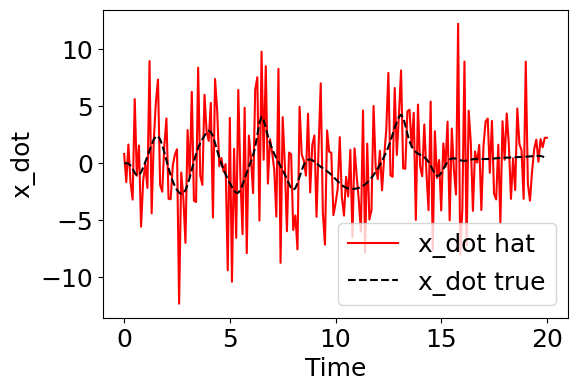

In [51]:
fd = pynumdiff.finite_difference.first_order
state_x_smooth, state_xdot_smooth = fd(state_x_noisy.values, dt, num_iterations=1)
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, state_x_smooth, label_var='x')
plot_tme(t_sim, x_sim_df['x_dot'], None, state_xdot_smooth, label_var='x_dot')

### Savitzy Golay Filter

Frequency domain sliding polynomial fit. Great option, very fast and simple.

<Axes: xlabel='Time', ylabel='x_dot'>

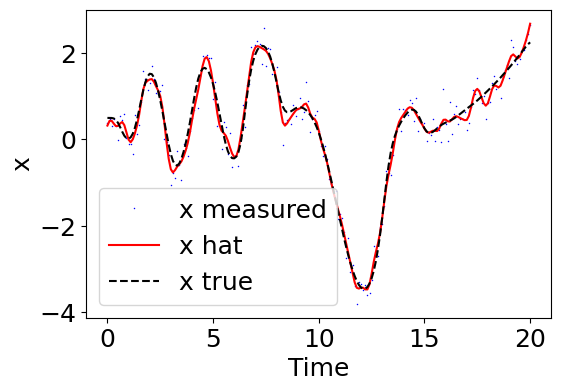

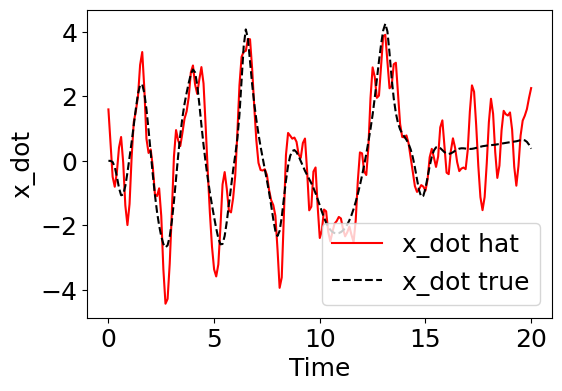

In [52]:
state_x_smooth, state_xdot_smooth = pynumdiff.savgoldiff(state_x_noisy, dt, degree=3, window_size=7, smoothing_win=7)
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, state_x_smooth, label_var='x')
plot_tme(t_sim, x_sim_df['x_dot'], None, state_xdot_smooth, label_var='x_dot')

### Spectral Derivative

Take a derivative in the frequency domain

<Axes: xlabel='Time', ylabel='x_dot'>

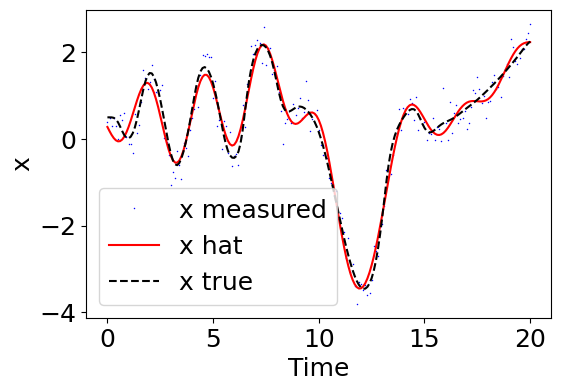

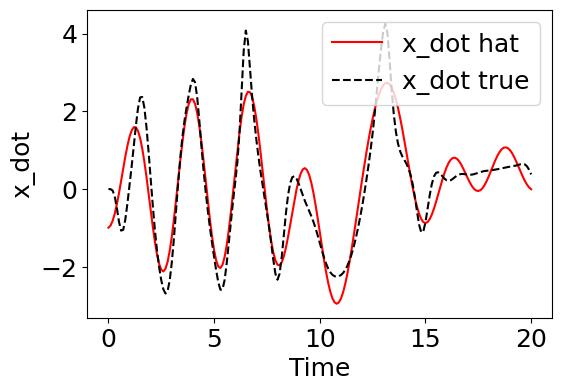

In [53]:
specdiff = pynumdiff.basis_fit.spectraldiff
state_x_smooth, state_xdot_smooth = specdiff(state_x_noisy.values, dt, even_extension=True,
                                             pad_to_zero_dxdt=True, high_freq_cutoff=0.085)
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, state_x_smooth, label_var='x')
plot_tme(t_sim, x_sim_df['x_dot'], None, state_xdot_smooth, label_var='x_dot')

### Total Variation Regularization

Finds a derivative that balances two goals:
1. The integral of the derivative should match the original signal.
2. The total variation of the derivative should be small (i.e. there should be minimal changes in the derivative from step to step).

Note: if you have cvxpy installed, and access to the cvxpy license (free for academic email), you can use a convex optimization implementation of TVR, and you can regularize the acceleration or jerk to get smoother derivatives.  

<Axes: xlabel='Time', ylabel='x_dot'>

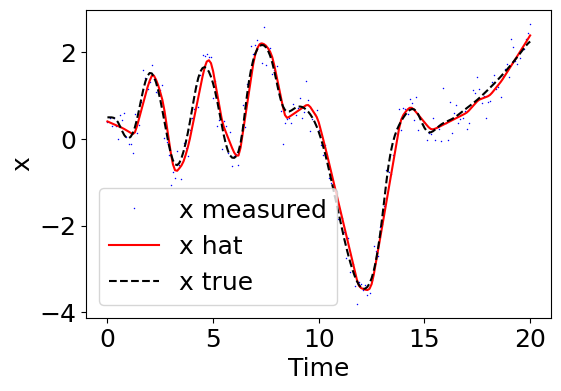

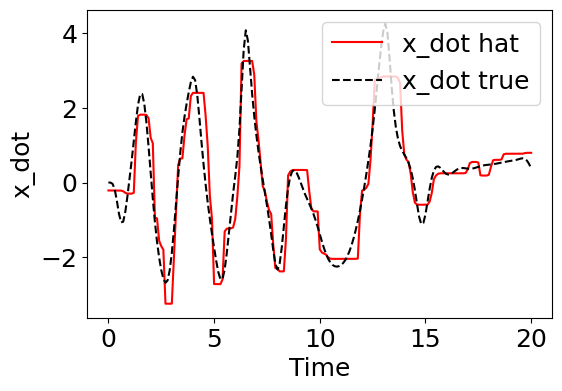

In [25]:
tvr = pynumdiff.total_variation_regularization.iterative_velocity
state_x_smooth, state_xdot_smooth = tvr(state_x_noisy, dt, num_iterations=10, gamma=0.1)
plot_tme(t_sim, x_sim_df['x'], state_x_noisy, state_x_smooth, label_var='x')
plot_tme(t_sim, x_sim_df['x_dot'], None, state_xdot_smooth, label_var='x_dot')

# Exercises:

1. Change the parameters of some of the methods above to get some intution as to their effect.
2. Choose a method. Plot the following metrics:
     * Root Mean Squared Error for the derivative estimates: $RMSE = \sqrt{ \sum_{i=0}^{N} (\hat{\dot{x}}_i - \dot{x}_i)^2 }$.
     * Error Correlation: Pearson's correlation coefficient ($R^2$). Hint: look up `scipy.stats.linregress`.
3. What are the implications of a high RMSE? What about a high Error Correlation?